In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib.ticker as ticker
from sklearn import svm
from collections import deque, defaultdict
from sklearn.ensemble import IsolationForest

In [2]:
df = pd.read_csv('numbers-on-unemployment-benefits1.csv')
df

,Month,Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992
0,1956-01,4742.0
1,1956-02,6128.0
2,1956-03,6494.0
3,1956-04,5379.0
4,1956-05,6011.0
...,...,...
435,1992-04,826297.0
436,1992-05,838390.0
437,1992-06,851831.0
438,1992-07,856505.0


In [3]:
# Изменим название столбца и удалим последнюю строку
df = df.iloc[:-1, :].rename(columns={'Numbers on Unemployment Benefits in Australia: monthly Jan 1956 ? Jul 1992':'Count'})

In [4]:
series_ = df.set_index('Month').iloc[:, -1]

In [5]:
series = df.iloc[:, -1]

In [6]:
def plot_ser(series, period=False, outliers=None):
    with plt.style.context(style='seaborn-bright'):
        fig, ax = plt.subplots(figsize=(14, 8))
        if not period:
            ax.minorticks_on()
            ax.grid(which='major', color = 'gray')
            ax.grid(which='minor', color = 'gray', linestyle = ':')
            ax.xaxis.set_major_locator(ticker.MultipleLocator(12))
            ax.xaxis.set_minor_locator(ticker.MultipleLocator(6))
            plt.xticks(rotation=90)
            ax.plot(series, color='blue')
        else:
            ax.plot(series.loc[period[0]:period[1]], color='blue')
            plt.xticks(rotation=30)
        
        if outliers is None:
            pass
        else:
            for i in outliers:
                ax.vlines(x=i, ymin=0, ymax=np.max(series), colors='r', linestyles='dotted')
          
        plt.title('Numbers on Unemployment Benefits in Australia')

Построим график ряда и попробуем определить визуально его точки изменения.

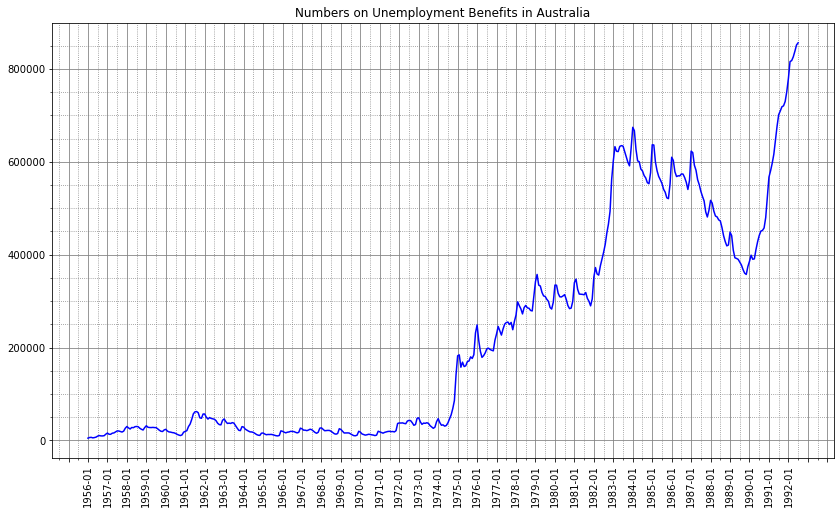

In [7]:
plot_ser(series_)

В этом ряде присутствуют: тренд, сезонность и цикличность(в начале ряда цикличность составляет 5 лет, с 1976 года она увеличивается).  

Точками изменения являются резкие увеличения:
1) в начале 1961 года  
2) в середине 1974 года  
3) в серединн 1982 года  
4) в конце 1986 года (хотя это может быть следствием цикличности)  
5) в середине 1990 года  

В остальных случаях изменения происходили в результате влияния тренда, сезонности, цикличности.  
Применим к этому ряду различные методы поиска аномалий.

## 1. С помощью среднего значения.

In [8]:
def simulate(detector, signal):
    stop_points = []
    for i, value in enumerate(signal):
        detector.update(value)
        if detector.check(value):
            stop_points.append(i)
    
    b = [i - j for i,j in zip(stop_points[:-1], stop_points[1:])]
    for k in range(len(b) - 1, -1, -1):
        if np.abs(b[k]) < 3:
            stop_points.pop(k + 1)
    
    plot_ser(signal)
        
    if stop_points:
        for i in stop_points:
            plt.vlines(x=i, ymin=0, ymax=np.max(signal),
                          colors='r', linestyles='dotted')
    plt.show()

In [9]:
class MeanDetector:
    def __init__(self, threshold=0.05):
        self.threshold = threshold
        self.total_val = 0
        self.count = 0
        self.mean = 0
    
    def update(self, new_signal_value):
        self.count += 1
        self.total_val += new_signal_value
        self.mean = self.total_val / self.count
    
    def check(self, new_signal_value): 
        threshold_level = self.mean * self.threshold
        
        if np.abs(new_signal_value - self.mean) > threshold_level:
            return True
        return False

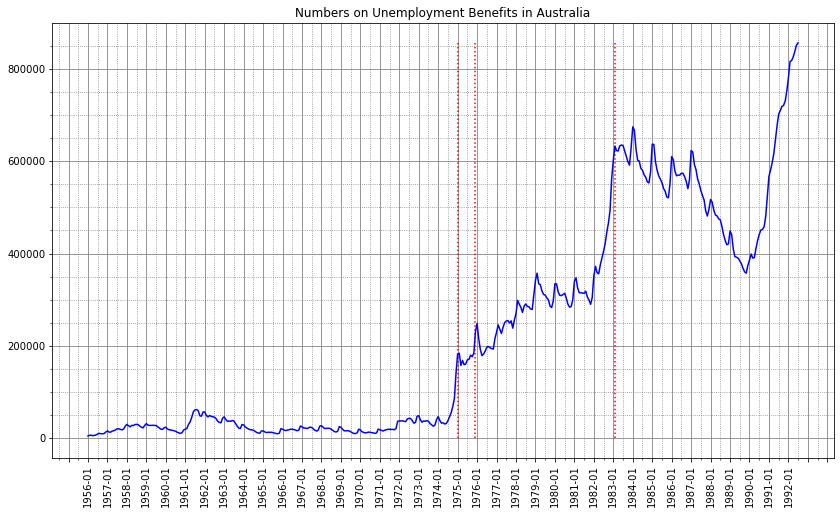

In [10]:
simulate(MeanDetector(threshold=5), series_)

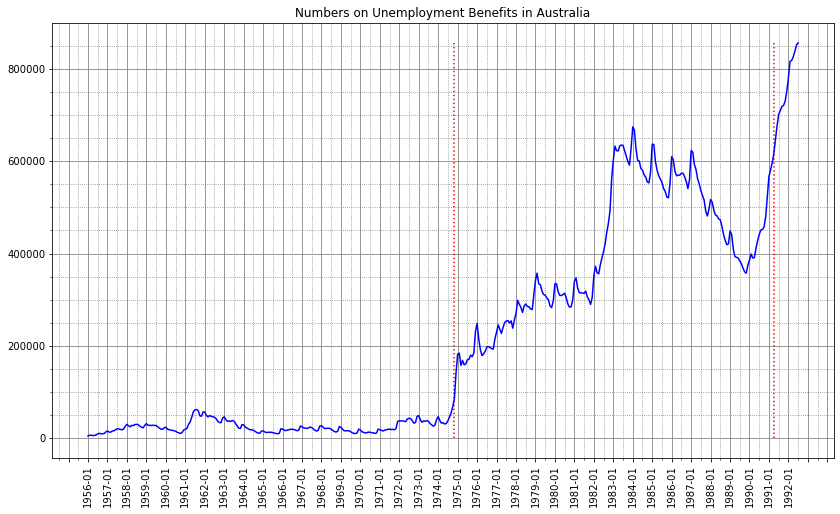

In [29]:
simulate(MeanDetector(threshold=2), series_)

С помощью подбора параметра этим методом можно определять различные аномалии. Но все сразу с одним параметром не получится, т.к. метод чувствителен к шуму, тренду, сезонности и выбросам.

## 2. С помощью потоковых окон. Метод Велфорда.

In [12]:
class ZScoreDetector:
    def __init__(self, window_size = 100, threshold=0.05):
        self.threshold = threshold
        self.window_size = window_size
        self.k = 0  
        self.g_mean = 0.0  # global mean  
        self.s = 0.0  # for Welford's method. variance = s / (k + 1)
        self.window = deque(maxlen = window_size)
        self.z_score = np.nan
        
    def update(self, new_signal_value):
        x = new_signal_value
        
        # Добавляем в окно
        self.window.append(x)
        
        # Считаем статистики
        oldm = self.g_mean
        newm = oldm + (x - oldm) / (self.k + 1)
        s = self.s + (x - newm) * (x - oldm)
        g_mean = newm 
        g_std = np.sqrt(s / (self.k+1))
        
        # Считаем статистикии по выборке
        w_mean = np.mean(self.window)
        w_std = np.std(self.window)

        # Считаем Z-score
        std_diff = (g_std - w_std) / g_std        
        SE = g_std / np.sqrt(self.window_size)
        mean_diff = (g_mean - w_mean) / g_mean
        self.z_score = (w_mean - g_mean) / SE
        
        # Обновлем атрибуты
        self.g_mean = g_mean
        self.s = s
        
        self.k += 1
    
    def check(self, new_signal_value):
        if np.abs(self.z_score) > self.threshold:
            return True
        return False

<ipython-input-12-f91433843e00>:29: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
<ipython-input-12-f91433843e00>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE


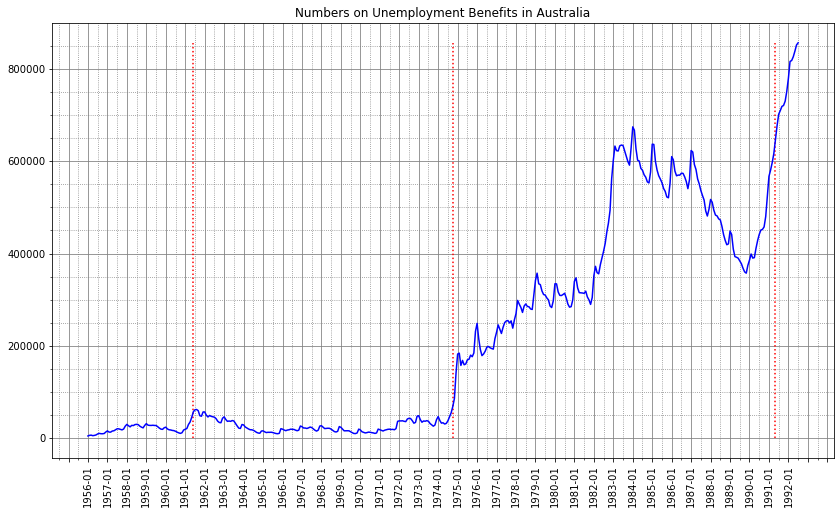

In [13]:
simulate(ZScoreDetector(window_size=5, threshold=4), series_)

<ipython-input-12-f91433843e00>:29: RuntimeWarning: invalid value encountered in double_scalars
  std_diff = (g_std - w_std) / g_std
<ipython-input-12-f91433843e00>:32: RuntimeWarning: invalid value encountered in double_scalars
  self.z_score = (w_mean - g_mean) / SE


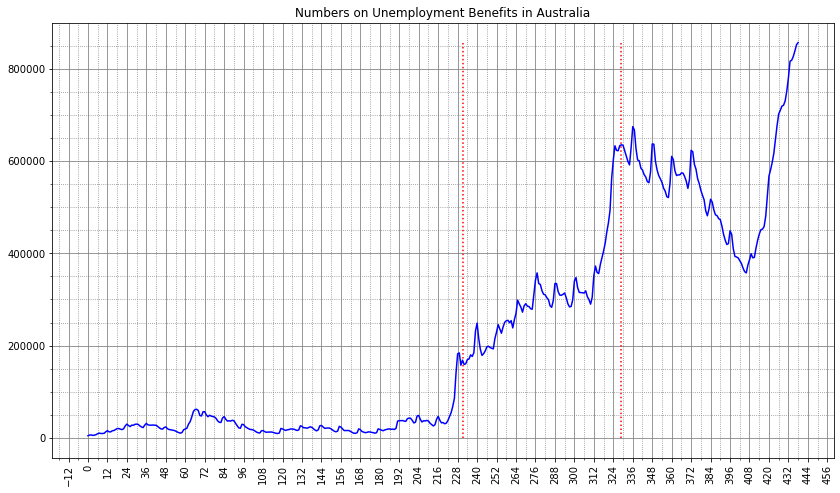

In [14]:
simulate(ZScoreDetector(window_size=10, threshold=10), series)

С помощью подбора параметров метод позволяет определить точки изменения. Этот метод не так чувствителен к выбросам, тренду и сезонности как предыдущий, но у него есть задержка в определении и не всегда актуален на практике из-за необходимости хранения данных.

## 3. Метод кумулятивных сумм.

In [15]:
def _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn):
    """Plot results of the detect_cusum function, see its help."""

    try:
        import matplotlib.pyplot as plt
    except ImportError:
        print('matplotlib is not available.')
    else:
        if ax is None:
            _, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

        t = range(x.size)
        ax1.plot(t, x, 'b-', lw=2)
        if len(ta):
            ax1.plot(tai, x[tai], '>', mfc='g', mec='g', ms=10,
                     label='Start')
            if ending:
                ax1.plot(taf, x[taf], '<', mfc='g', mec='g', ms=10,
                         label='Ending')
            ax1.plot(ta, x[ta], 'o', mfc='r', mec='r', mew=1, ms=5,
                     label='Alarm')
            ax1.legend(loc='best', framealpha=.5, numpoints=1)
        ax1.set_xlim(-.01*x.size, x.size*1.01-1)
        ax1.set_xlabel('Data #', fontsize=14)
        ax1.set_ylabel('Amplitude', fontsize=14)
        ymin, ymax = x[np.isfinite(x)].min(), x[np.isfinite(x)].max()
        yrange = ymax - ymin if ymax > ymin else 1
        ax1.set_ylim(ymin - 0.1*yrange, ymax + 0.1*yrange)
        ax1.set_title('Time series and detected changes ' +
                      '(threshold= %.3g, drift= %.3g): N changes = %d'
                      % (threshold, drift, len(tai)))
        ax2.plot(t, gp, 'y-', label='+')
        ax2.plot(t, gn, 'm-', label='-')
        ax2.set_xlim(-.01*x.size, x.size*1.01-1)
        ax2.set_xlabel('Data #', fontsize=14)
        ax2.set_ylim(-0.01*threshold, 1.1*threshold)
        ax2.axhline(threshold, color='r')
        ax1.set_ylabel('Amplitude', fontsize=14)
        ax2.set_title('Time series of the cumulative sums of ' +
                      'positive and negative changes')
        ax2.legend(loc='best', framealpha=.5, numpoints=1)
        plt.tight_layout()
        plt.show()

In [16]:
__author__ = 'Marcos Duarte, https://github.com/demotu/BMC'
__version__ = "1.0.4"
__license__ = "MIT"

def detect_cusum(x, threshold=1, drift=0, ending=False, show=True, ax=None):
    """Cumulative sum algorithm (CUSUM) to detect abrupt changes in data.

    Parameters
    ----------
    x : 1D array_like
        data.
    threshold : positive number, optional (default = 1)
        amplitude threshold for the change in the data.
    drift : positive number, optional (default = 0)
        drift term that prevents any change in the absence of change.
    ending : bool, optional (default = False)
        True (1) to estimate when the change ends; False (0) otherwise.
    show : bool, optional (default = True)
        True (1) plots data in matplotlib figure, False (0) don't plot.
    ax : a matplotlib.axes.Axes instance, optional (default = None).

    Returns
    -------
    ta : 1D array_like [indi, indf], int
        alarm time (index of when the change was detected).
    tai : 1D array_like, int
        index of when the change started.
    taf : 1D array_like, int
        index of when the change ended (if `ending` is True).
    amp : 1D array_like, float
        amplitude of changes (if `ending` is True).

    Notes
    -----
    Tuning of the CUSUM algorithm according to Gustafsson (2000)[1]_:
    Start with a very large `threshold`.
    Choose `drift` to one half of the expected change, or adjust `drift` such
    that `g` = 0 more than 50% of the time.
    Then set the `threshold` so the required number of false alarms (this can
    be done automatically) or delay for detection is obtained.
    If faster detection is sought, try to decrease `drift`.
    If fewer false alarms are wanted, try to increase `drift`.
    If there is a subset of the change times that does not make sense,
    try to increase `drift`.

    Note that by default repeated sequential changes, i.e., changes that have
    the same beginning (`tai`) are not deleted because the changes were
    detected by the alarm (`ta`) at different instants. This is how the
    classical CUSUM algorithm operates.

    If you want to delete the repeated sequential changes and keep only the
    beginning of the first sequential change, set the parameter `ending` to
    True. In this case, the index of the ending of the change (`taf`) and the
    amplitude of the change (or of the total amplitude for a repeated
    sequential change) are calculated and only the first change of the repeated
    sequential changes is kept. In this case, it is likely that `ta`, `tai`,
    and `taf` will have less values than when `ending` was set to False.

    See this IPython Notebook [2]_.

    References
    ----------
    .. [1] Gustafsson (2000) Adaptive Filtering and Change Detection.
    .. [2] hhttp://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/DetectCUSUM.ipynb

    Examples
    --------
    >>> from detect_cusum import detect_cusum
    >>> x = np.random.randn(300)/5
    >>> x[100:200] += np.arange(0, 4, 4/100)
    >>> ta, tai, taf, amp = detect_cusum(x, 2, .02, True, True)

    >>> x = np.random.randn(300)
    >>> x[100:200] += 6
    >>> detect_cusum(x, 4, 1.5, True, True)

    >>> x = 2*np.sin(2*np.pi*np.arange(0, 3, .01))
    >>> ta, tai, taf, amp = detect_cusum(x, 1, .05, True, True)
    """

    x = np.atleast_1d(x).astype('float64')
    gp, gn = np.zeros(x.size), np.zeros(x.size)
    ta, tai, taf = np.array([[], [], []], dtype=int)
    tap, tan = 0, 0
    amp = np.array([])
    # Find changes (online form)
    for i in range(1, x.size):
        s = x[i] - x[i-1]
        gp[i] = gp[i-1] + s - drift  # cumulative sum for + change
        gn[i] = gn[i-1] - s - drift  # cumulative sum for - change
        if gp[i] < 0:
            gp[i], tap = 0, i
        if gn[i] < 0:
            gn[i], tan = 0, i
        if gp[i] > threshold or gn[i] > threshold:  # change detected!
            ta = np.append(ta, i)    # alarm index
            tai = np.append(tai, tap if gp[i] > threshold else tan)  # start
            gp[i], gn[i] = 0, 0      # reset alarm
    # THE CLASSICAL CUSUM ALGORITHM ENDS HERE

    # Estimation of when the change ends (offline form)
    if tai.size and ending:
        _, tai2, _, _ = detect_cusum(x[::-1], threshold, drift, show=False)
        taf = x.size - tai2[::-1] - 1
        # Eliminate repeated changes, changes that have the same beginning
        tai, ind = np.unique(tai, return_index=True)
        ta = ta[ind]
        # taf = np.unique(taf, return_index=False)  # corect later
        if tai.size != taf.size:
            if tai.size < taf.size:
                taf = taf[[np.argmax(taf >= i) for i in ta]]
            else:
                ind = [np.argmax(i >= ta[::-1])-1 for i in taf]
                ta = ta[ind]
                tai = tai[ind]
        # Delete intercalated changes (the ending of the change is after
        # the beginning of the next change)
        ind = taf[:-1] - tai[1:] > 0
        if ind.any():
            ta = ta[~np.append(False, ind)]
            tai = tai[~np.append(False, ind)]
            taf = taf[~np.append(ind, False)]
        # Amplitude of changes
        amp = x[taf] - x[tai]

    if show:
        _plot(x, threshold, drift, ending, ax, ta, tai, taf, gp, gn)

    return ta, tai, taf, amp

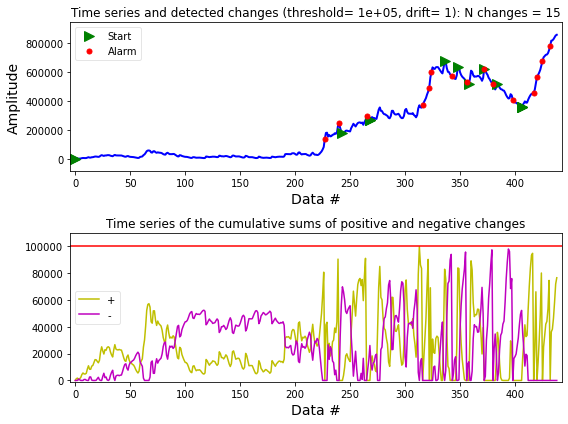

(array([227, 240, 265, 316, 322, 324, 343, 356, 372, 380, 398, 417, 420,
        425, 432]),
 array([  0,   0, 243, 268, 268, 268, 336, 348, 358, 372, 384, 406, 406,
        406, 406]),
 array([], dtype=int32),
 array([], dtype=float64))

In [17]:
detect_cusum(series, threshold=100000, drift=1, ending=False, show=True, ax=None)

Может у меня не получилось настроить параметры, хотя я подбирал  по рекомендации в описании функции, но для нашего ряда метод оказался чувствительным к совокупности тренда, сезонности и цикла.

## 4. Метод опорных векторов для одного класса (OneClass SVM).

<ipython-input-18-f1bb47b3abc6>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  false_positive_train = np.array(false_positive_train)
<ipython-input-18-f1bb47b3abc6>:25: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  false_positive_test = np.array(false_positive_test)
<ipython-input-18-f1bb47b3abc6>:29: UserWarning: No contour levels were found within the data range.
  plt.contour([0, 439], y, Z, levels=[0], linewidths=10, colors='darkred')


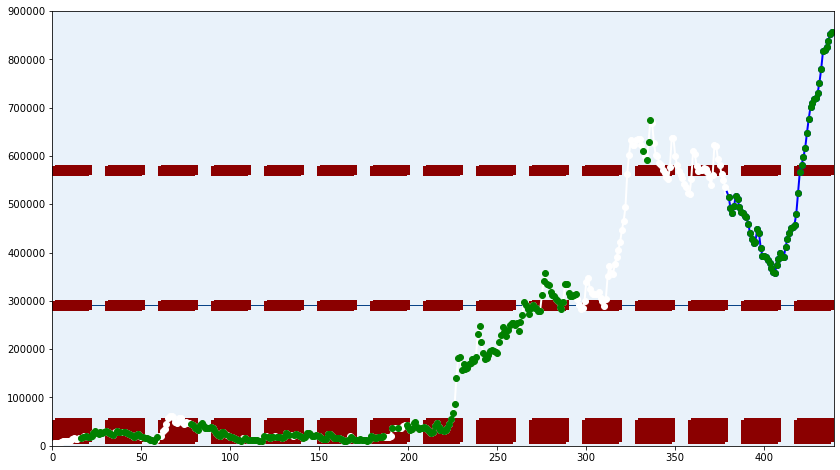

In [18]:
signal = series.values.reshape(-1, 1)
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.05)
clf.fit(signal[:380])

y_pred_train = clf.predict(signal[:380])
y_pred_test = clf.predict(signal[380:])

y = np.linspace(0, 900000, 500).reshape(-1, 1)
Z = clf.decision_function(y).reshape(-1, 1)
Z = np.hstack((Z, Z))
y = y.reshape(500)

false_positive_train = []
false_positive_test = []
for i, t in enumerate(y_pred_train):
    if t != 1:
        false_positive_train.append((i, signal[i]))
        
for i, t in enumerate(y_pred_test):
    if t != 1:
        idx = len(y_pred_train) + i
        false_positive_test.append((idx, signal[idx]))

false_positive_train = np.array(false_positive_train)
false_positive_test = np.array(false_positive_test)

plt.figure(figsize=(14,8))
plt.contourf([0, 439], y, Z, cmap=plt.cm.Blues)
plt.contour([0, 439], y, Z, levels=[0], linewidths=10, colors='darkred')
plt.plot(range(380), signal[:380], 'wo', linewidth=10)
plt.plot(range(380), signal[:380], 'w-', linewidth=2)
plt.plot(range(380,439), signal[380:], 'bo', linewidth=10)
plt.plot(range(379,439), signal[379:], 'b-', linewidth=2)
plt.plot(false_positive_train[:, 0], false_positive_train[:, 1], 'go')
plt.plot(false_positive_test[:, 0], false_positive_test[:, 1], 'go')
plt.show()

С помощью подбора параметров не удалось отделить гиперплоскостью аномальные значения. Возможно этот метод плохо подходит для нашего ряда.

## 5. Изолирующий лес (Isolation Forest).

Построим модель с подбором параметра.

In [19]:
clf_if = IsolationForest(contamination=0.07)
clf_if.fit(df[['Count']])

IsolationForest(contamination=0.07)

In [20]:
df['Outliers'] = pd.Series(clf_if.predict(df[['Count']]))

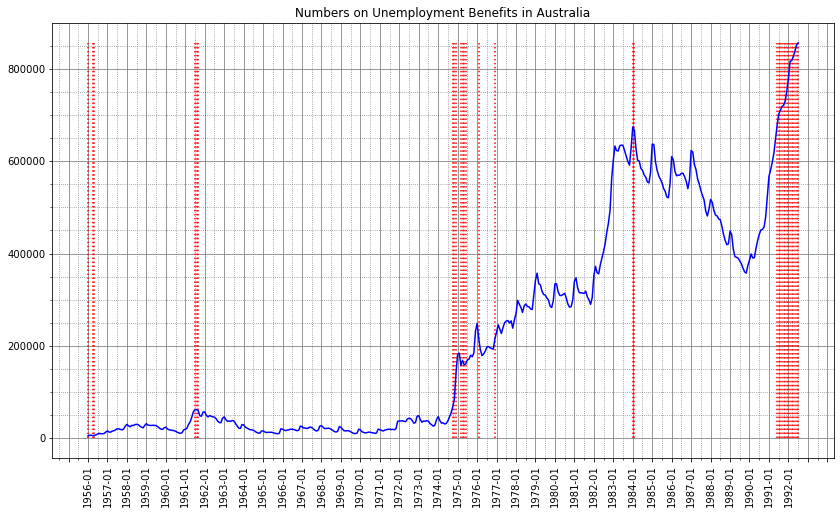

In [21]:
plot_ser(series_, outliers=df.query('Outliers == -1')['Month'].values)

Оставим автоматический подбор параметра модели. Аномальные значения отделим с помощью оценок модели аномальных значений (чем меньше оценка, тем значение более аномально).

In [22]:
clf_if = IsolationForest()
clf_if.fit(df[['Count']])

IsolationForest()

In [23]:
score = clf_if.decision_function(df[['Count']])

<function matplotlib.pyplot.show(close=None, block=None)>

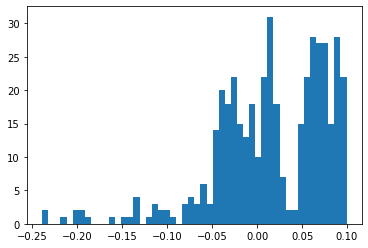

In [24]:
# Построим гистрограмму оценок модели
plt.hist(score, bins=50)
plt.show

Посмотрим на значения с оценкой модели $score < -0.075$.

In [25]:
df['scores'] = score

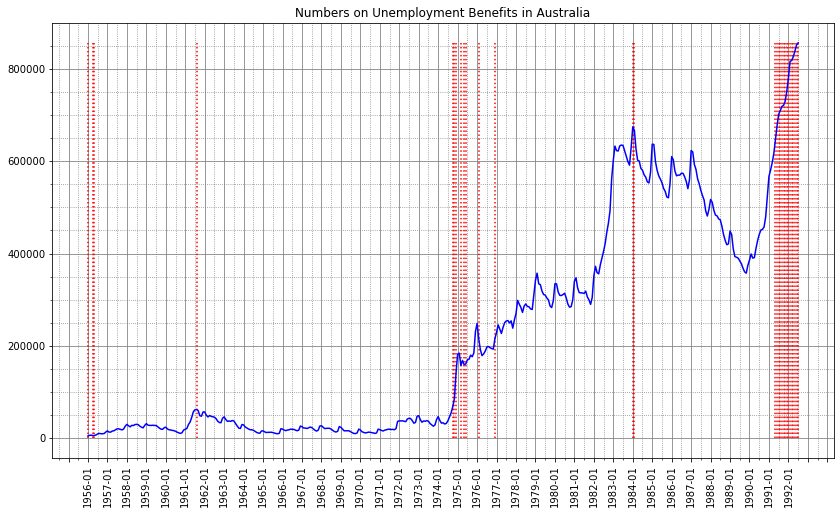

In [26]:
plot_ser(series_, outliers=df.query('scores < -0.075')['Month'].values)

Модель определяет как аномальные значения так и значения, соответствующие тренду и сезонности. У модели есть проблема переобучения.

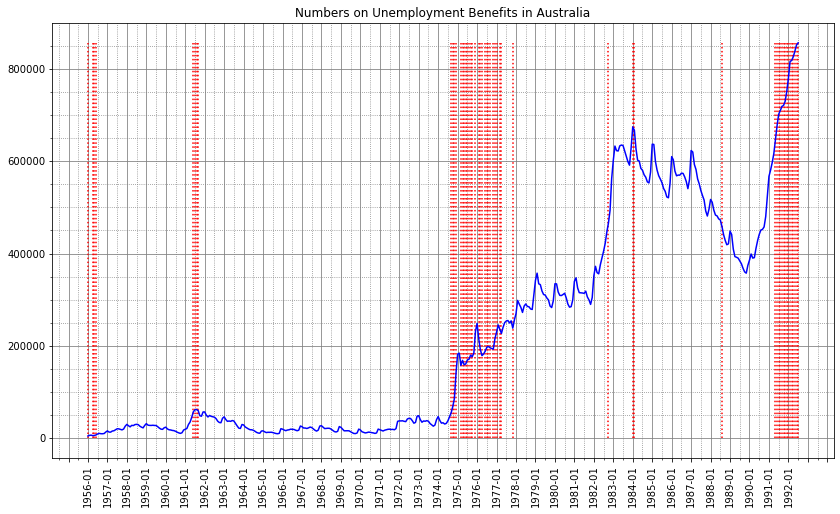

In [47]:
clf_if = IsolationForest(contamination=0.12)
clf_if.fit(df[['Count']])

df['Outliers'] = pd.Series(clf_if.predict(df[['Count']]))

plot_ser(series_, outliers=df.query('Outliers == -1')['Month'].values)

Модель определяет аномальное значение в середине 1982 года вместе с другими не аномальными значениями.

## Вывод:  
Для поиска аномалий к нашему ряду лучше всего подходит метод потоковых окон.